<a href="https://colab.research.google.com/github/tha-thanida/Add-Drop-Form/blob/main/banknote_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow # Installs TensorFlow library
!pip install keras # Installs keras library

In [ ]:
from google.colab import drive
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers , models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications import efficientnet_v2 , NASNetLarge
import tensorflow_hub as hub
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import os
from datetime import datetime

%matplotlib inline

In [ ]:
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_path = "/content/drive/MyDrive/Thai banknote dataset/Train" # @param{type:"string"}
test_path = "/content/drive/MyDrive/Thai banknote dataset/Test" # @param{type:"string"}
valid_path = "/content/drive/MyDrive/Thai banknote dataset/Valid" # @param{type:"string"}

In [ ]:
# @title 2.1. Set up Custom parameter Datagen { display-mode: "form" }
ROTATION_RANGE = 10 # @param {type:"number"}
HORIZONTAL_FLIP = True # @param{type:"boolean"}
VERTICAL_FLIP = False # @param{type:"boolean"}
ZOOM_RANGE = 0.1 # @param {type:"number"}
WIDTH_SHIFT_RANGE = 0.1 # @param {type:"number"}
HEIGHT_SHIFT_RANGE = 0.1 # @param {type:"number"}

BATCH_SIZE = 32 # @param{type:"integer"}
IMAGE_SIZE = 224 # @param{type:"integer"}

In [ ]:
# @title 2.2 Run ImageDataGenerator

train_datagen = ImageDataGenerator( width_shift_range = WIDTH_SHIFT_RANGE ,
                                   height_shift_range = HEIGHT_SHIFT_RANGE,
                                   rotation_range =  ROTATION_RANGE ,
                                   horizontal_flip =  HORIZONTAL_FLIP ,
                                   vertical_flip = VERTICAL_FLIP ,
                                   zoom_range = ZOOM_RANGE)
train_generator = train_datagen.flow_from_directory(
        directory=train_path,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical')


test_datagen = ImageDataGenerator( width_shift_range = WIDTH_SHIFT_RANGE ,
                                   height_shift_range = HEIGHT_SHIFT_RANGE,
                                   rotation_range =  ROTATION_RANGE ,
                                   horizontal_flip =  HORIZONTAL_FLIP ,
                                   vertical_flip = VERTICAL_FLIP ,
                                   zoom_range = ZOOM_RANGE)
test_generator = test_datagen.flow_from_directory(
        directory=test_path,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle = False,
        class_mode='categorical')


valid_datagen = ImageDataGenerator( width_shift_range = WIDTH_SHIFT_RANGE ,
                                   height_shift_range = HEIGHT_SHIFT_RANGE,
                                   rotation_range =  ROTATION_RANGE ,
                                   horizontal_flip =  HORIZONTAL_FLIP ,
                                   vertical_flip = VERTICAL_FLIP ,
                                   zoom_range = ZOOM_RANGE)
valid_generator = valid_datagen.flow_from_directory(
        directory=valid_path,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle = False,
        class_mode='categorical')



Found 2100 images belonging to 10 classes.
Found 453 images belonging to 10 classes.
Found 450 images belonging to 10 classes.


In [ ]:
class_names = train_generator.class_indices
class_names

{'100': 0,
 '1000': 1,
 '20': 2,
 '50': 3,
 '500': 4,
 'fake100': 5,
 'fake1000': 6,
 'fake20': 7,
 'fake50': 8,
 'fake500': 9}

In [ ]:
CLASS_SIZE = len(class_names)

In [ ]:
import random
SEED = 42
os.environ['PYTHONHASHSEED']=str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # TF 2.1
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

#set seed

In [ ]:
# @title เลือก Model ที่นำมาใช้ Train
model_name = "RestNet-50" # @param ["MobileNetV3Small", "RestNet-50",  "EfficientNetV2L", "NASNetLarge"]

In [ ]:
if model_name =="MobileNetV3Small" :
  base_model = keras.applications.MobileNetV3Small(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),include_top=False, weights='imagenet') # Load the MobileNetV3Small model
  base_model.trainable = True # Enable to train Pre-Trained Model
if model_name == "RestNet-50":
  base_model = ResNet50(
    input_shape = [IMAGE_SIZE , IMAGE_SIZE ] + [3], # Making the image into 3 Channel, so concating 3.
    weights = 'imagenet', # Default weights.
    include_top = False   #
  )
  base_model.trainable = True # Enable to train Pre-Trained Model
if model_name == "EfficientNetV2L":
  base_model = efficientnet_v2.EfficientNetV2B0(include_top=False,
                                                input_shape= [IMAGE_SIZE , IMAGE_SIZE ] + [3],
                                                weights="imagenet")

if model_name == "NASNetLarge":
  base_model = NASNetLarge(

    include_top=False,
    input_shape = [IMAGE_SIZE , IMAGE_SIZE ] + [3],
    weights="imagenet",
  )


inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer") # Define input layer


94765736/94765736 [==============================] - 2s 0us/step


In [ ]:
x = inputs # Apply Augmentation to the input images. this use for decrease overfit
x = base_model(x, training=False) # Pass Augmentation Data to base_model
x = layers.GlobalAveragePooling2D(name="GloPool")(x) # Create Global Average Pooling and input x to get output tensor that value = Dense's filter. this use for decrease feature map
outputs = tf.keras.layers.Dense(CLASS_SIZE, activation="softmax", name="output_layer")(x) # output layer that (output unit = CLASS_SIZE as image class, activation function is softmax  )
model_0 = tf.keras.Model(inputs, outputs) # Create Model name model_0 that have input layer, base mosel, output layer
model_0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=["accuracy"]) #Compile model_0 with categorical_crossentropy, adam's learning rate = 0.0001, metric by accuracy


In [ ]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 GloPool (GlobalAveragePool  (None, 2048)              0         
 ing2D)                                                          
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23608202 (90.06 MB)
Trainable params: 23555082 (89.86 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [ ]:
custom_early_stopping = EarlyStopping( # EarlyStopping is keras's callback function that stop training model before overfitting
    monitor='val_loss', # monitor at validation loss
    patience=10,
    min_delta=0.000000001, # if validation loss is not decrease at least 0.001 in 10 time
    mode='min' # need validtion loss to decrease
)

In [ ]:
start = datetime.now()

history = model_0.fit(train_generator, # Use from train generator
           epochs=30, # training round
           workers=0,
           steps_per_epoch=len(train_generator), # Use from batch size that can update each epoch for training
           validation_data=valid_generator, # Use from test generator
           validation_steps=len(valid_generator),
           callbacks=[custom_early_stopping]) # Stop training when overfitting

print ('Execution Time: ',datetime.now()-start)

Epoch 1/30
66/66 [==============================] - 791s 11s/step - loss: 1.4129 - accuracy: 0.5062 - val_loss: 1.3398 - val_accuracy: 0.5400
Epoch 2/30
66/66 [==============================] - 86s 1s/step - loss: 0.3392 - accuracy: 0.8919 - val_loss: 0.6644 - val_accuracy: 0.7956
Epoch 3/30
66/66 [==============================] - 87s 1s/step - loss: 0.1429 - accuracy: 0.9486 - val_loss: 0.8080 - val_accuracy: 0.7533
Epoch 4/30
66/66 [==============================] - 87s 1s/step - loss: 0.0540 - accuracy: 0.9814 - val_loss: 0.7025 - val_accuracy: 0.8089
Epoch 5/30
66/66 [==============================] - 89s 1s/step - loss: 0.0414 - accuracy: 0.9886 - val_loss: 0.6937 - val_accuracy: 0.8289
Epoch 6/30
66/66 [==============================] - 87s 1s/step - loss: 0.0183 - accuracy: 0.9933 - val_loss: 1.5506 - val_accuracy: 0.7200
Epoch 7/30
66/66 [==============================] - 88s 1s/step - loss: 0.1457 - accuracy: 0.9590 - val_loss: 0.6819 - val_accuracy: 0.8222
Epoch 8/30
66/66 [

In [ ]:
#@title 3.2. Evaluate the model on the test set
test_loss, test_acc = model_0.evaluate_generator(test_generator, steps=len(test_generator))
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

<ipython-input-17-74d96c32e9dc>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = model_0.evaluate_generator(test_generator, steps=len(test_generator))


Test loss: 1.6642524003982544
Test accuracy: 0.6490066051483154


In [ ]:
# Evaluate the model on the test set
start = datetime.now()
test_loss, test_acc = model_0.evaluate_generator(test_generator, steps=len(test_generator))
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)
print('Test Time:',datetime.now()-start)


<ipython-input-18-0897c54d69da>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = model_0.evaluate_generator(test_generator, steps=len(test_generator))


Test loss: 1.6796436309814453
Test accuracy: 0.6423841118812561
Test Time: 0:00:18.454269


15/15 [==============================] - 20s 1s/step


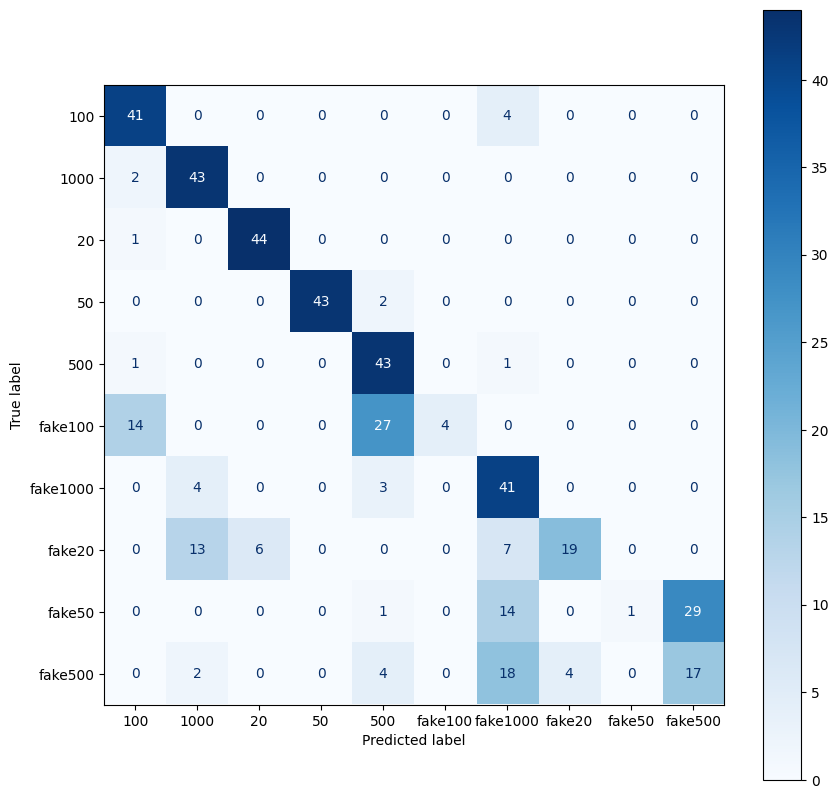

,class,specificity,sensitivity
0,0,0.955882,0.911111
1,1,0.953431,0.955556
2,2,0.985294,0.977778
3,3,1.000000,0.955556
4,4,0.909314,0.955556
5,5,1.000000,0.088889
6,6,0.891358,0.854167
7,7,0.990196,0.422222
8,8,1.000000,0.022222
9,9,0.928922,0.377778


In [ ]:
import sklearn as scikit_learn
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

test_true=test_generator.classes[test_generator.index_array]
test_pred_raw = model_0.predict(test_generator)
test_pred = np.argmax(test_pred_raw, axis=1)

cm = confusion_matrix(test_true, test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax,cmap=plt.cm.Blues)
plt.show()


res = []
for l in range(CLASS_SIZE):
    pres,recall,_,_ = precision_recall_fscore_support(np.array(test_true)==l,np.array(test_pred)==l,pos_label=True,average=None)
    res.append([l,recall[0],recall[1]])

pd.DataFrame(res,columns = ['class','specificity','sensitivity'])


In [ ]:
from sklearn.metrics import classification_report


report = classification_report(test_true, test_pred, target_names=class_names)
print(report)


              precision    recall  f1-score   support

         100       0.69      0.91      0.79        45
        1000       0.69      0.96      0.80        45
          20       0.88      0.98      0.93        45
          50       1.00      0.96      0.98        45
         500       0.54      0.96      0.69        45
     fake100       1.00      0.09      0.16        45
    fake1000       0.48      0.85      0.62        48
      fake20       0.83      0.42      0.56        45
      fake50       1.00      0.02      0.04        45
     fake500       0.37      0.38      0.37        45

    accuracy                           0.65       453
   macro avg       0.75      0.65      0.59       453
weighted avg       0.75      0.65      0.59       453



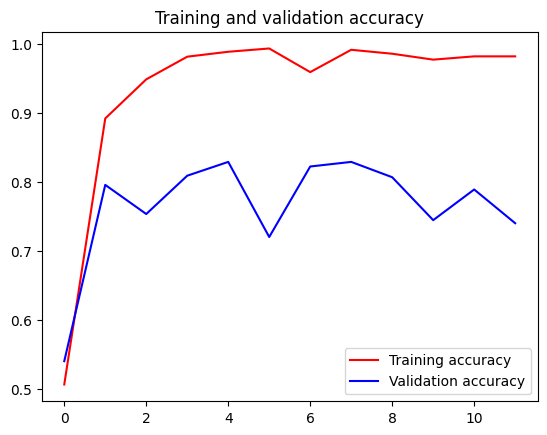

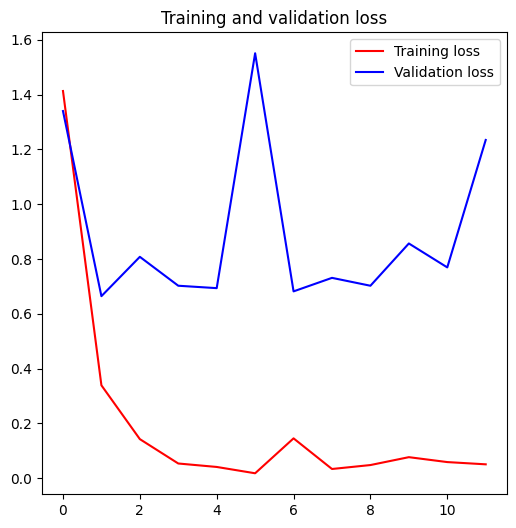

<Figure size 600x600 with 0 Axes>

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure(figsize=(6,6))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure(figsize=(6,6))

plt.show()


In [ ]:
# Save the trained model to a .h5 file
model_0.save('/content/gdrive/MyDrive/Thai banknote/model/trainedmodel.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from keras.models import load_model
model = load_model('/content/gdrive/MyDrive/Thai banknote/model/trainedmodel.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_LATENCY]
tflite_model = converter.convert()
open("/content/gdrive/MyDrive/Thai banknote/model/tflitemodel.tflite", "wb").write(tflite_model)

23950952

In [ ]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  file_name=fn

Saving S__21512281_0.jpg to S__21512281_0 (1).jpg
User uploaded file "S__21512281_0 (1).jpg" with length 284388 bytes


1/1 [==============================] - 0s 29ms/step
Image name: S__21512281_0 (1).jpg
Predicted class: fake500 (99.95%)
Prediction:  ['0.00%', '0.00%', '0.00%', '0.00%', '0.05%', '0.00%', '0.00%', '0.00%', '0.00%', '99.95%']


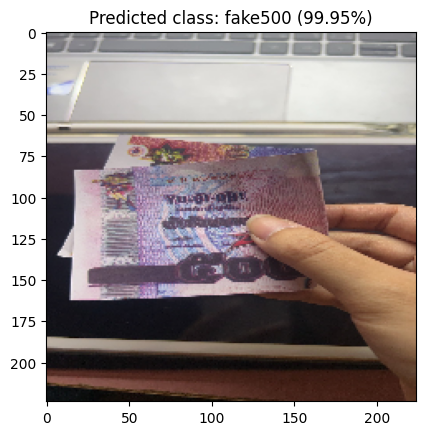

In [ ]:
img = image.load_img(file_name, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.mobilenet_v3.preprocess_input(img_array)

    # Make prediction
prediction = model.predict(img_array)
class_names = train_generator.class_indices
class_names = {v: k for k, v in class_names.items()} # reverse the class_indices dictionary
predicted_class = np.argmax(prediction, axis=1)
predicted_class_name = class_names[predicted_class[0]]
predicted_prob = np.max(prediction, axis=1)

    # Print the result
print("Image name:", file_name)
print("Predicted class: {} ({:.2f}%)".format(predicted_class_name, predicted_prob[0]*100))
prediction_list = prediction.tolist() # Convert the NumPy array to a Python list
prediction_formatted = ["{:.2%}".format(p) for p in prediction_list[0]]
print("Prediction: ", prediction_formatted)
plt.imshow(img)
plt.title("Predicted class: {} ({:.2f}%)".format(predicted_class_name, predicted_prob[0]*100))
plt.show()
print("\n")